In [19]:
#| echo: false
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

In [20]:
# Set path to target data in data folder
cwd = Path.cwd()
cwd.parent.parent
target_data_path = cwd.parent.parent / Path("data/target-data/case-data.csv")

In [21]:
# Load in target data from WHO weekly time series
target_data = pd.read_csv(target_data_path, index_col=0)
target_data.index = pd.to_datetime(target_data.index)

In [22]:
# Specify fixed parameters and get calibration data
proc_update_freq = 21
init_time = 50
data = target_data['New_cases_MYS']
pop = 33e6
analysis_start = datetime(2021, 4, 15)
analysis_end = datetime(2021, 10, 30)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = data.loc[analysis_start: analysis_end]
#init_data = init_data_2.loc[init_start: init_end]
#init_data = data.loc[init_start: init_end]/7
init_data = data.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [223]:
init_start

datetime.datetime(2021, 2, 24, 0, 0)

In [225]:
init_end

datetime.datetime(2021, 4, 14, 0, 0)

In [23]:
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [24]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.4, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(4, 10),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(6, 0.5, low=0.0),
    "report_sd": dist.TruncatedNormal(2, 0.5, low=0.0),
}

In [25]:
#| output: false
calib = StandardCalib(renew_model, priors, select_data, indicator='weekly_sum')
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=100, num_warmup=100)
mcmc.run(random.PRNGKey(1))

Running chain 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.30it/s]


In [26]:
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=200)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

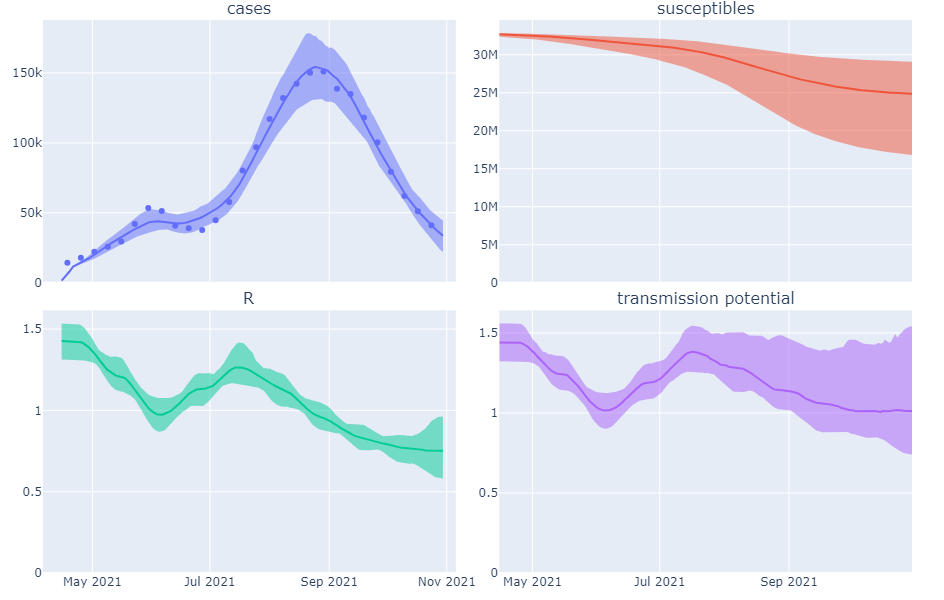

In [27]:
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)
panel_subtitles = ["weekly_sum"] + PANEL_SUBTITLES[1:]
spaghetti = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles)
quantiles_df = get_quant_df_from_spaghetti(renew_model, spaghetti, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles)
plot_uncertainty_patches(quantiles_df, select_data, qual_colours.Plotly, panel_subtitles).update_layout(showlegend=False)

In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.296,0.128,0.117,0.553,0.014,0.010,83.0,140.0,1.03
dispersion,0.204,0.027,0.161,0.257,0.002,0.001,187.0,152.0,1.01
gen_mean,7.238,0.360,6.590,7.930,0.024,0.017,227.0,150.0,1.02
gen_sd,3.877,0.478,3.131,4.828,0.032,0.023,224.0,161.0,1.01
proc[0],-0.146,0.085,-0.283,0.033,0.006,0.004,225.0,167.0,1.01
proc[1],-0.206,0.101,-0.387,-0.028,0.008,0.006,169.0,128.0,1.01
proc[2],0.164,0.102,0.003,0.361,0.007,0.005,192.0,155.0,1.00
proc[3],0.148,0.098,-0.070,0.315,0.008,0.006,161.0,158.0,1.02
proc[4],-0.063,0.094,-0.245,0.134,0.006,0.005,239.0,225.0,1.00
proc[5],-0.099,0.094,-0.270,0.065,0.005,0.005,312.0,146.0,1.01


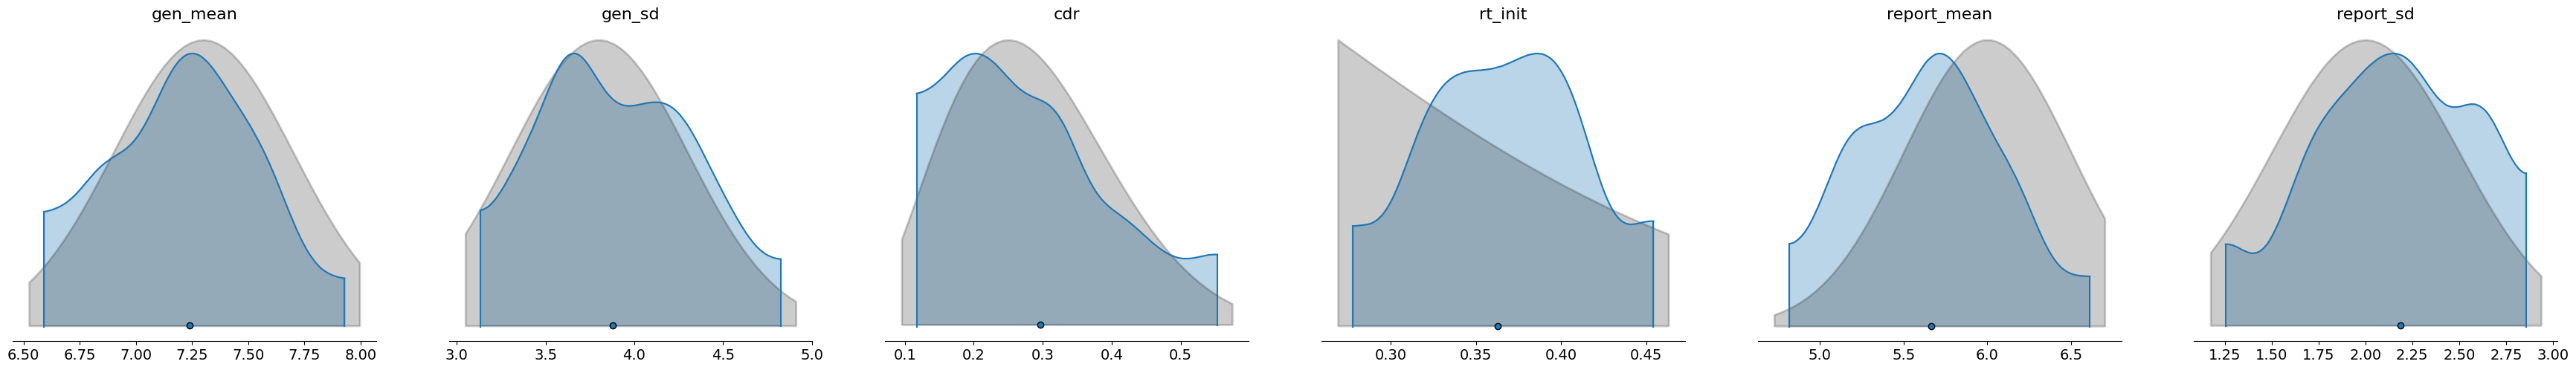

In [29]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);

In [17]:
Markdown(renew_model.get_description())



### Fixed parameters
The main analysis period runs from 15<sup>th</sup>  April  2021 to 30<sup>th</sup>  October  2021, with a preceding run in period of {self.run_in} days. The starting model population is 33.0 million persons. 

### Variable process
Because the analysis period is not an exact multiple of the duration of a process interval, the run-in period is extended from {self.run_in} days to 2 days. Fitting is implemented using a half-cosine interpolation function that is translated and scaled to reach each of the points specified. This results in a function that joins each two successive requested values with a function that scales smoothly from a gradient of zero at the preceding point to a gradient of zero at the subsequent point. After curve fitting, the sequence of parameter values pertaining to the variable process are exponentiated, such that parameter exploration for these quantities is undertaken in the log-transformed space. 

### Generation times
Generation times for each day are calculated by first finding the parameters needed to construct a gamma distribution with mean and standard deviation equal to those specified by the submitted parameter values. The integrals of the probability density of this distribution between consecutive integer values are then calculated for later combination with the incidence time series. The generation interval for all calculations is truncated from 50 days, on the assumption that the distribution's density has reached negligible values once this period has elapsed. 

### Renewal process
Calculation of the renewal process consists of multiplying the incidence values for the preceding days by the reversed generation time distribution values. This follows a standard formula, described elsewhere by several groups,[@cori2013; @faria2021] i.e. $$i_t = R_t\sum_{\tau<t} i_\tau g_{t-\tau}$$
$R_t$ is calculated as the product of the proportion of the population remaining susceptible and the non-mechanistic random process generated external to the renewal model. The susceptible population is calculated by subtracting the number of new incident cases from the running total of susceptibles at each iteration. If incidence exceeds the number of susceptible persons available for infection in the model, incidence is capped at the remaining number of susceptibles. 